<center>
<h1>NFL Data Analysis</h1>
<h3>This is part 2 in a 2 Notebook excercise in leveraging Spark to perform simple Data Engineering and Analysis using NFL Data provided by "Burnt Sushi".</h3>

<img src="https://github.com/bradenrc/nfl_spark/raw/master/intro2.png" style="width:60%;height:60%"/>

</center>

In [1]:
games_norm_df = sqlContext.read.parquet("./games_norm_df_p/")
games_norm_df.registerTempTable("games")

distinct_games_weather_df = sqlContext.read.parquet("./weather_p/")
distinct_games_weather_df.registerTempTable("weather")

<h3>Incoroporate all of the data from Burnt Sushi NFLDB</h3>

In [2]:
connection_d = {'url':'jdbc:postgresql://bluemix-sandbox-dal-9-portal.2.dblayer.com:15656/compose',
                'dbtable':'play_player',
                'user':'admin',
                'password':'RFSUPYGYXCMNKGUN'}  

connection_d["dbtable"] = "drive"
drive_df = sqlContext.read.format('jdbc').options(**connection_d).load()
drive_df.registerTempTable("drive")

connection_d["dbtable"] = "play"
play_df = sqlContext.read.format('jdbc').options(**connection_d).load()
play_df.registerTempTable("play")

connection_d["dbtable"] = "team"
team_df = sqlContext.read.format('jdbc').options(**connection_d).load()
team_df.registerTempTable("team")

connection_d["dbtable"] = "player"
player_df = sqlContext.read.format('jdbc').options(**connection_d).load()
player_df.registerTempTable("player")

connection_d["dbtable"] = "play_player"
play_player_df = sqlContext.read.format('jdbc').options(**connection_d).load()
play_player_df.registerTempTable("play_player")

Grab the counts of each table

In [3]:
print "Games: ", games_norm_df.count()
print "Weather (distinct games): ", distinct_games_weather_df.count()
print "Drives: ", drive_df.count()
print "Player Plays: ", play_player_df.count()
print "Plays: ", play_df.count()
print "Players: ", player_df.count()
print "Teams:: ", team_df.count()

Games:  5276
Weather (distinct games):  2630
Drives:  57914
Player Plays:  956777
Plays:  432606
Players:  7451
Teams::  35


Print out the schema of each table

In [4]:
print "Games: ", games_norm_df.printSchema()
print "Weather (distinct games): ", distinct_games_weather_df.printSchema()
print "Drives: ", drive_df.printSchema()
print "Player Plays: ", play_player_df.printSchema()
print "Plays: ", play_df.printSchema()
print "Players: ", player_df.printSchema()
print "Teams:: ", team_df.printSchema()

Games:  root
 |-- GSIS_ID: string (nullable = false)
 |-- GAMEKEY: string (nullable = true)
 |-- START_TIME: timestamp (nullable = false)
 |-- WEEK: integer (nullable = false)
 |-- DAY_OF_WEEK: string (nullable = false)
 |-- SEASON_YEAR: integer (nullable = false)
 |-- SEASON_TYPE: string (nullable = false)
 |-- FINISHED: boolean (nullable = false)
 |-- LOCATION: string (nullable = false)
 |-- HOME_GAME: integer (nullable = false)
 |-- TEAM: string (nullable = false)
 |-- SCORE: integer (nullable = false)
 |-- SCORE_Q1: integer (nullable = true)
 |-- SCORE_Q2: integer (nullable = true)
 |-- SCORE_Q3: integer (nullable = true)
 |-- SCORE_Q4: integer (nullable = true)
 |-- SCORE_Q5: integer (nullable = true)
 |-- TURNOVERS: integer (nullable = false)
 |-- OPPONENT_TEAM: string (nullable = false)
 |-- OPPONENT_SCORE: integer (nullable = false)
 |-- OPPONENT_SCORE_Q1: integer (nullable = true)
 |-- OPPONENT_SCORE_Q2: integer (nullable = true)
 |-- OPPONENT_SCORE_Q3: integer (nullable = tru

<h3>Visualize One Game (Eli Manning September 5th 2012)</h3>

In [5]:
#example of one game for Eli Manning

query = """
select
    pp.PLAY_ID,
    PASSING_YDS
from games g

INNER JOIN drive d on
    g.GSIS_ID = d.GSIS_ID

INNER JOIN play_player pp on
    g.GSIS_ID = pp.GSIS_ID
    and pp.DRIVE_ID = d.DRIVE_ID

INNER JOIN player p on
    p.PLAYER_ID = pp.PLAYER_ID
    and g.TEAM = p.TEAM

where g.GSIS_ID = 2012090500
        and p.FULL_NAME = 'Eli Manning'
order by 
    g.GSIS_ID,
    d.DRIVE_ID,
    p.PLAYER_ID,
    pp.PLAY_ID """

plays_manning_df = sqlContext.sql(query)
plays_manning_pd = plays_manning_df.toPandas()

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt, numpy as np

Example 1 uses Pandas and matplotlib

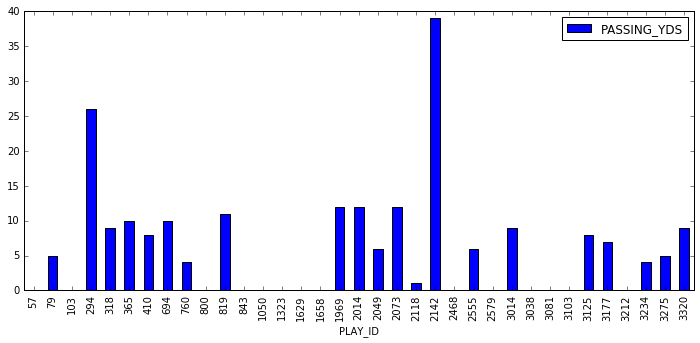

In [7]:
plays_manning_pd.plot(kind='bar', x='PLAY_ID', y='PASSING_YDS', figsize=(12, 5))

Example 2 uses the Brunel library<br>
More details here: <a href: http://brunel.mybluemix.net/docs/>http://brunel.mybluemix.net/docs/</a>

In [8]:
#Since it is supported natively, there is nothing to install just reference your Pandas Datafram
import brunel
%brunel data('plays_manning_pd') bar x(PLAY_ID) y(PASSING_YDS) :: width=800, height=500

<IPython.core.display.Javascript object>

<h4>The same game, but "rolling sum" to show the progressive yards gained by Eli during the game</h4>

In [13]:
#Rolling sum to show the progression of the game

plays_manning_df.registerTempTable("manning")

query = """
select
    a.PLAY_ID,
    a.PASSING_YDS,
    sum(b.PASSING_YDS) as Total_Yards
from
 manning a
inner join manning b
    on a.PLAY_ID >= b.PLAY_ID
GROUP BY
    a.PLAY_ID, a.PASSING_YDS
order by
    a.PLAY_ID desc
"""
pd = sqlContext.sql(query).toPandas()

In [14]:
%brunel data('pd') bar x(PLAY_ID) y(Total_Yards) :: width=800, height=500

<IPython.core.display.Javascript object>

Using joins to the other tables created, you can determine the most passing yards by player

In [15]:
#Who has the most passing yards in the record set (top 15)
query = """
SELECT 
	player.FULL_NAME, 
	SUM(play_player.PASSING_YDS) AS passing_yds
FROM play_player
INNER JOIN player ON 
    player.PLAYER_ID = play_player.PLAYER_ID
INNER JOIN games ON 
    games.GSIS_ID = play_player.GSIS_ID
    and games.TEAM = player.TEAM
WHERE 
	games.season_type = 'Regular'
	AND PASSING_YDS > 0
GROUP BY player.FULL_NAME
ORDER BY SUM(play_player.PASSING_YDS) desc
limit 15
"""

pd = sqlContext.sql(query).toPandas()

In [16]:
%brunel data('pd') bar x(FULL_NAME) y(passing_yds) color(FULL_NAME)  transpose :: width=800, height=500

<IPython.core.display.Javascript object>

We can also determine most passing yards by team, with a count of Quarterbacks who played

In [17]:
#what about the team with the most passing yards
query = """
SELECT 
	player.TEAM, 
	SUM(play_player.PASSING_YDS) AS passing_yds,
    COUNT(distinct player.FULL_NAME) as players
FROM play_player
INNER JOIN player ON 
    player.PLAYER_ID = play_player.PLAYER_ID
INNER JOIN games ON 
    games.GSIS_ID = play_player.GSIS_ID
    and games.TEAM = player.TEAM
WHERE 
	games.season_type = 'Regular'
	AND PASSING_YDS > 0
GROUP BY player.TEAM
ORDER BY SUM(play_player.PASSING_YDS) desc
limit 15
"""
pd = sqlContext.sql(query).toPandas()

In [18]:
pd

,TEAM,passing_yds,players
0,NO,36590,2
1,NE,33217,4
2,SD,32679,2
3,ATL,31247,2
4,NYG,31217,3
5,PIT,30511,6
6,GB,29010,1
7,DET,27700,3
8,BAL,27435,3
9,DAL,26551,4


In [19]:
#pd.plot(kind='barh', stacked=True, y='passing_yds', x="TEAM", figsize=(14, 8))
%brunel data('pd') bar x(TEAM) y(passing_yds) color(TEAM)  transpose + data('pd') line x(TEAM) y(players) transpose :: width=800, height=500 

<IPython.core.display.Javascript object>

<h3>Incorporate weather and compare the weather to the yards thrown by quarterback</h3>

In [20]:
import json
#the weather table has a column that contains all of the JSON returned for each day\locaton queried 
#in most cases we are only interested in some basic observations, so the first step is to pull those out

#We can build a function to pull out the value that we want and return the metric

#here is an example of the data we are working with:

example_data = distinct_games_weather_df.take(1)

for rrow in example_data:
    #let's just pick the 12th value assuming that roughly the middle of the day is sufficienct
    #for the analysis
    print json.dumps(rrow.weather["observations"][12], sort_keys=True, indent=4, separators=(',', ': '))
    print "*" * 20

    #or to see a specific value
    print rrow.weather["observations"][12]["temp"]
    print "*" * 20

{
    "blunt_phrase": null,
    "class": null,
    "clds": null,
    "day_ind": null,
    "dewPt": 37,
    "expire_time_gmt": 1419765300,
    "feels_like": 46,
    "gust": null,
    "heat_index": 46,
    "icon_extd": 2600,
    "key": null,
    "max_temp": null,
    "min_temp": null,
    "obs_id": null,
    "obs_name": null,
    "precip_hrly": 0,
    "precip_total": null,
    "pressure": null,
    "pressure_desc": null,
    "pressure_tend": null,
    "primary_swell_direction": null,
    "primary_swell_height": null,
    "primary_swell_period": null,
    "primary_wave_height": null,
    "primary_wave_period": null,
    "qualifier": null,
    "qualifier_svrty": null,
    "rh": 71,
    "secondary_swell_direction": null,
    "secondary_swell_height": null,
    "secondary_swell_period": null,
    "snow_hrly": null,
    "temp": 46,
    "terse_phrase": null,
    "uv_desc": null,
    "uv_index": 0,
    "valid_time_gmt": 1419758100,
    "vis": 10,
    "water_temp": null,
    "wc": 46,
    "wdir"

In [21]:
#now create a function that takes the JSON blob and returns a value
import types

def get_w_metric(metric, datablob):
    i = 10
    try:
        for obs in datablob["observations"][11:20]:
            if obs[metric]: 
                #return obs[metric]
                return str(obs[metric])
    except:
        return 'na'

sqlContext.registerFunction("get_w_metric", get_w_metric)

In [22]:
#test the function

query = "select *, get_w_metric('temp', weather) as temp from weather  limit 10"
sqlContext.sql(query).show()

+----------+--------+--------------------+--------+--------+---------+------------+--------------------+----+
|   GSIS_ID|LOCATION|          START_TIME| datekey|latitude|longitude|stadium_city|             weather|temp|
+----------+--------+--------------------+--------+--------+---------+------------+--------------------+----+
|2014122812|     WAS|2014-12-28 12:00:...|20141228|  38.908|  -76.864|Landover, MD|Map(metadata -> n...|  41|
|2015082051|     WAS|2015-08-20 18:30:...|20150820|  38.908|  -76.864|Landover, MD|Map(metadata -> n...|  77|
|2015120700|     WAS|2015-12-07 19:30:...|20151207|  38.908|  -76.864|Landover, MD|Map(metadata -> n...|  34|
|2009082850|     WAS|2009-08-28 19:00:...|20090828|  38.908|  -76.864|Landover, MD|Map(metadata -> n...|  73|
|2009092008|     WAS|2009-09-20 12:00:...|20090920|  38.908|  -76.864|Landover, MD|Map(metadata -> n...|  52|
|2014120708|     WAS|2014-12-07 12:00:...|20141207|  38.908|  -76.864|Landover, MD|Map(metadata -> n...|  39|
|201510250

In [23]:
#create a dataframe with weather metrics
query = """ select 
                *, 
                get_w_metric('temp', weather) as temp,
                get_w_metric('vis', weather) as vis,
                get_w_metric('precip_hrly', weather) as precip_hrly,
                get_w_metric('heat_index', weather) as heat_index,
                get_w_metric('wspd', weather) as wspd,
                get_w_metric('precip_total', weather) as precip_total,
                get_w_metric('pressure', weather) as pressure
        from weather """
distinct_games_weather_df_wmetrics = sqlContext.sql(query)
distinct_games_weather_df_wmetrics.registerTempTable("weather_metrics")

In [24]:
distinct_games_weather_df_wmetrics.show(5)

+----------+--------+--------------------+--------+--------+---------+------------+--------------------+----+---+-----------+----------+----+------------+--------+
|   GSIS_ID|LOCATION|          START_TIME| datekey|latitude|longitude|stadium_city|             weather|temp|vis|precip_hrly|heat_index|wspd|precip_total|pressure|
+----------+--------+--------------------+--------+--------+---------+------------+--------------------+----+---+-----------+----------+----+------------+--------+
|2014122812|     WAS|2014-12-28 12:00:...|20141228|  38.908|  -76.864|Landover, MD|Map(metadata -> n...|  41| 10|       null|        41|   3|        null|    null|
|2015082051|     WAS|2015-08-20 18:30:...|20150820|  38.908|  -76.864|Landover, MD|Map(metadata -> n...|  77| 10|       null|        78|   3|        null|    null|
|2015120700|     WAS|2015-12-07 19:30:...|20151207|  38.908|  -76.864|Landover, MD|Map(metadata -> n...|  34| 10|       null|        34|   3|        null|    null|
|2009082850|    

In [25]:
query = """

select 
    *
from
    games g
inner join weather_metrics w on
    g.GSIS_ID = w.GSIS_ID
limit 5
"""
sqlContext.sql(query).toPandas()

,GSIS_ID,GAMEKEY,START_TIME,WEEK,DAY_OF_WEEK,SEASON_YEAR,SEASON_TYPE,FINISHED,LOCATION,HOME_GAME,...,longitude,stadium_city,weather,temp,vis,precip_hrly,heat_index,wspd,precip_total,pressure
0,2014122106,56403,2014-12-21 12:00:00,16,Sunday,2014,Regular,True,PIT,0,...,-80.016,"Pittsburgh, PA",{u'observations': [{u'primary_wave_period': No...,29,10,None,29,3,None,None
1,2015102500,56595,2015-10-25 08:30:00,7,Sunday,2015,Regular,True,JAC,0,...,-81.638,"Jacksonville, FL",{u'observations': [{u'primary_wave_period': No...,81,10,None,84,5,None,None
2,2014122107,56404,2014-12-21 12:00:00,16,Sunday,2014,Regular,True,TB,0,...,-82.503,"Tampa, FL",{u'observations': [{u'primary_wave_period': No...,76,10,None,76,7,None,None
3,2014122108,56405,2014-12-21 15:05:00,16,Sunday,2014,Regular,True,STL,0,...,-118.28,"Los Angeles, CA",{u'observations': [{u'primary_wave_period': No...,64,6,None,64,None,None,None
4,2014122109,56406,2014-12-21 15:25:00,16,Sunday,2014,Regular,True,DAL,0,...,-97.093,"Arlington, TX",{u'observations': [{u'primary_wave_period': No...,46,10,None,46,None,None,None


Now that we have some weather data to look at, let's start with average temperature by team

In [26]:
query = """

select 
    g.TEAM,
    avg(w.temp) as avgtempi,
    avg(w.wspd) as avgwspd
from
    games g
inner join weather_metrics w on
    g.GSIS_ID = w.GSIS_ID
where g.TEAM != 'UNK'
group by g.TEAM
order by avgtempi desc

"""
pd = sqlContext.sql(query).toPandas()

In [27]:
%brunel data('pd') bar x(TEAM) y(avgtempi) color(TEAM) sort(avgtempi) :: width=800, height=500 

<IPython.core.display.Javascript object>

Using Brunel we can bucket this into 15 buckets and see which teams are outliers

In [28]:
%brunel data('pd') y(avgtempi) label(avgtempi,TEAM) rank(avgtempi) axes(x) list(TEAM) bin(avgtempi:15) color(avgtempi) legends(none)

<IPython.core.display.Javascript object>

Using a point chart we can map out the Wind\Temp. Note the tooltip values so we can highlight the points and determine what they are.

In [185]:
#%brunel data('pd') bar x(TEAM) y(avgtempi) color(TEAM) sort(avgtempi):: width=800, height=300 
%brunel data('pd') point x(avgtempi) y(avgwspd) tooltip(TEAM, avgtempi, avgwspd) color(TEAM) :: width=800, height=600    

<IPython.core.display.Javascript object>

Now create a simple table that has each players game, yards thrown and temp

In [29]:
query = """SELECT
    games.GSIS_ID,
	player.TEAM,
	player.FULL_NAME,
	player.PROFILE_ID,
	sum(play_player.PASSING_YDS) AS passing_yds,
	avg(w.temp) as temp
FROM play_player
INNER JOIN player ON 
    player.PLAYER_ID = play_player.PLAYER_ID
INNER JOIN games ON 
    games.GSIS_ID = play_player.GSIS_ID
    and games.TEAM = player.TEAM
INNER JOIN weather_metrics w ON
    w.GSIS_ID = games.GSIS_ID
WHERE 
	games.SEASON_TYPE = 'Regular'
	AND PASSING_YDS > 0
    AND w.temp is not null
GROUP BY FULL_NAME, PROFILE_ID, player.TEAM, games.GSIS_ID
ORDER BY FULL_NAME, PROFILE_ID
"""

players_yards = sqlContext.sql(query)
players_yards.registerTempTable("players_yards")

Using the corr function, we can determine the correlation between passing yards and temp

In [30]:
#build list of players to loop through
query = """
select
    FULL_NAME,
    count(*) as games,
    corr(passing_yds, temp) as corr
from
    players_yards
group by FULL_NAME

"""
sqlContext.sql(query).registerTempTable("temp_yds_corr")

In [31]:
query = "select * from temp_yds_corr where abs(corr) > 0 order by corr"
players_pd = sqlContext.sql(query).toPandas()

Now we can chart, the size represents the number of games played.

In [32]:
#players_pd.plot(kind="bar", x="FULL_NAME", y="corr", figsize=(14, 8));
#%brunel data('pd') bar x(TEAM) y(avgtempi) color(TEAM) sort(avgtempi):: width=800, height=300 
%brunel data('players_pd')  x(FULL_NAME) y(corr) tooltip(FULL_NAME, corr, games) color(FULL_NAME) size(games) :: width=800, height=600    

<IPython.core.display.Javascript object>

In [34]:
query = "select * from temp_yds_corr where abs(corr) > CAST('.5' AS FLOAT) order by games desc"
players_pd = sqlContext.sql(query).toPandas()
players_pd

,FULL_NAME,games,corr
0,Chad Henne,28,-0.597849
1,Matt McGloin,9,-0.529300
2,Colt McCoy,6,0.752440
3,Sam Bradford,5,-0.573254
4,Brock Osweiler,5,0.944697
5,Trevor Siemian,5,-0.739225
6,Case Keenum,5,0.661009
7,Mark Sanchez,3,0.910390
8,Kellen Moore,3,-0.766237
9,Bruce Gradkowski,3,-0.953433


<h4>Interesting... Mariota has a correlation and 12 games, let's plot it out.</h4>
<img src="https://lintvkhon.files.wordpress.com/2015/07/marcus-mariota-sandy-beach-interview.jpg?w=400" align="left"></img>

In [191]:
query = """
select
    *
from
    players_yards
where 
    FULL_NAME = 'Marcus Mariota' 
order by temp
"""
players_pd = sqlContext.sql(query).toPandas()
players_pd

,GSIS_ID,TEAM,FULL_NAME,PROFILE_ID,passing_yds,temp
0,2015122005,TEN,Marcus Mariota,2552466,32,41
1,2015101806,TEN,Marcus Mariota,2552466,231,58
2,2015111503,TEN,Marcus Mariota,2552466,185,58
3,2015120604,TEN,Marcus Mariota,2552466,268,59
4,2015112907,TEN,Marcus Mariota,2552466,218,59
5,2016091802,TEN,Marcus Mariota,2552466,239,64
6,2015110803,TEN,Marcus Mariota,2552466,371,65
7,2015121301,TEN,Marcus Mariota,2552466,274,66
8,2015092003,TEN,Marcus Mariota,2552466,262,67
9,2015092709,TEN,Marcus Mariota,2552466,367,68


Notice on this chart that we can add a second line for the "fit" giving us a linear representation.

In [192]:
%brunel data('players_pd') line x(temp) y(passing_yds) fit(passing_yds) +  data('players_pd') line x(temp) y(passing_yds)  :: width=800, height=600   

<IPython.core.display.Javascript object>

We can also take a quick look at Chad Henne, who had high correlation with many games. <br>
<img src="https://pbs.twimg.com/media/CUOcnxjUkAA1knO.jpg" />

In [193]:
query = """
select
    *
from
    players_yards
where 
    FULL_NAME = 'Chad Henne' 
order by temp
"""
players_pd = sqlContext.sql(query).toPandas()
players_pd        

,GSIS_ID,TEAM,FULL_NAME,PROFILE_ID,passing_yds,temp
0,2012123005,JAC,Chad Henne,252,298,31
1,2013122904,JAC,Chad Henne,252,331,41
2,2013112404,JAC,Chad Henne,252,239,47
3,2012112503,JAC,Chad Henne,252,261,52
4,2012122304,JAC,Chad Henne,252,348,52
5,2013101308,JAC,Chad Henne,252,304,52
6,2012120206,JAC,Chad Henne,252,208,52
7,2014091407,JAC,Chad Henne,252,193,54
8,2012110800,JAC,Chad Henne,252,121,58
9,2012102109,JAC,Chad Henne,252,77,60


In [194]:
%brunel data('players_pd') line x(temp) y(passing_yds) fit(passing_yds) +  data('players_pd') line x(temp) y(passing_yds) :: width=800, height=600   

<IPython.core.display.Javascript object>

In [40]:
players_yards.toPandas().to_csv('players_yards.csv')

In [ ]:
!pwd

/gpfs/fs01/user/s2fc-631a29225e9565-5626aa220b46/notebook/work


In [38]:
!pwd

/gpfs/fs01/user/s2fc-631a29225e9565-5626aa220b46/notebook/work
